<a href="https://colab.research.google.com/github/Levis0045/SCIA-CRF_LF/blob/0.1/training/experimentations_crf_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sangkak AI Challenge: NER tasks

--------------------------------------------------------------------------

- **Author**: Elvis MBONING (NTeALan Research and Development Team)
- **Session**: février 2023

--------------------------------------------------------------------------

In this notebook, we try to implement new methods which can potentialy improved NER task in low african resource languages.

We propose a rule-based approach call **Position to position entity augmentation** to normalize and augment lowest training data for CRF model. Our work is based on this paper (Xiang Dai and Heike Adel, 2020)[https://aclanthology.org/2020.coling-main.343.pdf].

# Experiments

In this experiment, we want to build ML model based on Conditional Random Field (CRF). 

## 1- Data processing and analysis

### 1.1. Loading data from Masakhane folder


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Install python packages dependencies
!pip3 install pandas python_crfsuite summarytools sklearn_crfsuite unidecode
!pip3 install iteration_utilities matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.3/784.3 KB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.2/385.2 KB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 KB 39.3 MB/s eta 0:00:00
  Created wheel for summarytools: filename

In [3]:
# Download Masakhane dataset from Github
!git clone https://github.com/masakhane-io/masakhane-ner.git

Cloning into 'masakhane-ner'...
remote: Enumerating objects: 3923, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 3923 (delta 78), reused 103 (delta 50), pack-reused 3734
Receiving objects: 100% (3923/3923), 54.21 MiB | 20.28 MiB/s, done.
Resolving deltas: 100% (1666/1666), done.
Updating files: 100% (2133/2133), done.


In [1]:
# loading default libraries
from pathlib import Path
import pandas as pd
from auglib import read_format_iob_data

In [7]:
# Reading folder path
# Context Masahkane community
# Ramshaw and Marcus (1995) = IOB data format


bbj_ner_path = Path('../data_source/masakhane-ner/MasakhaNER2.0/data/bbj')
dev_data_path   = bbj_ner_path / 'dev.txt'
train_data_path = bbj_ner_path / 'train.txt'


In [8]:
# read and extract iob data
extracted_train_data, pd_train_data, only_train_ner_data, o_train_ner_data = read_format_iob_data(train_data_path)
extracted_dev_data, pd_dev_data, only_dev_ner_data, o_dev_ner_data = read_format_iob_data(dev_data_path)

# some stats 
print("Total number of sentences in the train dataset: {:,}".format(pd_train_data["sentence_id"].nunique()))
print("Total words in the train dataset: {:,}".format(pd_train_data.shape[0]))
print("Total number of sentences in the dev dataset: {:,}".format(pd_dev_data["sentence_id"].nunique()))
print("Total words in the dev dataset: {:,}".format(pd_dev_data.shape[0]))

Total number of sentences in the train dataset: 3,384
Total words in the train dataset: 50,623
Total number of sentences in the test dataset: 966
Total words in the test dataset: 15,924
Total number of sentences in the dev dataset: 483
Total words in the dev dataset: 7,745



#### Quelques observations liminaires

- A la lecture des données d'entrainement, il semble nécéssaire de les normaliser en appliquant quelques corrections
  - ajout de point à la fin des phrases qui n'en ont pas 
  - considérer les tirets comme partie de "I-LOC" ?
  - ŋkaʼ (6) est à la fois O et B-DATE+chiffre (37)
  - non standardisation de l'orthographe: 
      Afrika I-ORG  / Afríkà B-LOC / Afrikǎ I-LOC / Afrika B-LOC / Afrika I-ORG
      / afika B-LOC / Afríka B-LOC / Africa I-ORG / Afrika O / Afríkâ B-LOC

      Nəmo B-ORG / NƏMO O / Nə̀mò B-ORG

- Les données d'entraiement sont assez limitées et disproportionnées entre les tags. 

- Il semble utile de construire une stratégie d'augmentation sur les entités existantes
  - explorer les stratégies existantes 
  - développer de nouvelles stratégies
  

---------------------------------------------------------------

### 1.2. Augment training data from Masakhane folder

Data augmentation is used here because our previous experimentations without it don't give use us unexpected results. Many papers in the litterature show that data augmentation can improve model performance in many tasks. 

We developped a new simple rule-based data augmentation build on top of entity position on each training sentence. 

Why position it is important here ? Just because many syntactic structures of african language are positionals. We can then capitalize on this positionality to augment sentences based on labelled word position in the sentence. In the same way, we can conclude that NER word are also positional and we can interchange its occurences with others NER word in all training sentences.

cf. check the file `auglib.py` python file for implementations and examples.

In [9]:
# load augmentation library
import joblib
from datetime import datetime
from auglib import augment_ner_iob_data, list_to_pd_format


In [10]:
# augment training data 
augmented_train_ner_data = augment_ner_iob_data(only_train_ner_data)

# print(f'lenght Train data: {len(only_train_ner_data)} \n lenght Augmented data: {len(augmented_train_ner_data)}')

lenght Train data: 1771 
 lenght Augmented data: 1219850


In [11]:
# Transform augmented training data to dataframe
pd_augment_ner_iob_data = list_to_pd_format(augmented_train_ner_data)
pd_augment_ner_iob_data

,sentence_id,word,iob_tag
0,1,A,O
1,1,shə́ŋ,O
2,1,gaə́,O
3,1,DG,O
4,1,Cameroon,B-ORG
...,...,...,...
20391456,1906795,pú,O
20391457,1906795,pútə́,O
20391458,1906795,é,O
20391459,1906795,lə,O


In [ ]:
# saving augmented data
project = "sangkak-02-2023-aug"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "train_augmented": augmented_train_ner_data, 
    "pd_train_augmented": pd_augment_ner_iob_data
}, f'preprocessing/sangkak_train_data_augmented_{build_date}.joblib')


### 1.3. Analyzing data 

In [12]:
# load dependents python packages
from matplotlib import pyplot as plt
import numpy as np

In [13]:
# quantification des tags/phrases dans le corpus d'entrainement
# credit: https://github.com/6chaoran/jupyter-summarytools
from summarytools import dfSummary, tabset

tabset({
    "train_data": dfSummary(pd_train_data).render(),
    "augmented_train_data": dfSummary(pd_augment_ner_iob_data).render(),
    #"test_data": dfSummary(pd_test_data).render(),
    "dev_data": dfSummary(pd_dev_data).render()
})

# Un controle visuel des données et ce tableau montre clairement qu'il y a 
# des problématiques de cohérence d'annotations avec l'usage du format IOB.

/tmp/ipykernel_44881/2607832914.py:6: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "train_data": dfSummary(pd_train_data).render(),
/tmp/ipykernel_44881/2607832914.py:7: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "augmented_train_data": dfSummary(pd_augment_ner_iob_data).render(),
/tmp/ipykernel_44881/2607832914.py:8: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "test_data": dfSummary(pd_test_data).render(),
/tmp/ipykernel_44881/2607832914.py:9: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  "dev_data": dfSummary(pd_dev_data).render()


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,sentence_id[int64],Mean (sd) : 1723.3 (1003.2)min < med < max:1.0 < 1745.0 < 3384.0IQR (CV) : 1804.0 (1.7),"3,384 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACv0lEQVR4nO3dv27aUBiG8e9AACdBRigt2bJ0rNSBkYvoxfYSgsQVMHTplA0JIRBuEI6hQ0VVqeKPz7GLX+f5regklvPo+HyAFLff7w2ousa1LwC4xM21LwD14Zy7NbO25/Ltfr9/PfYioaIQzrnbh4eHr3Ec933Wr1arhXPu27FYCRVFacdx3B+NRq+9Xm+TZ+FyuYwmk0l/Pp+3zYxQUb5er7cZDAY/PZbennqRYQoSCBUSSn30B06BZmcmQbwfpYUaOgWanZ8E8X6UuaN6T4Fml02CKFbgEzDe7XatIq/nb6VP/QFToGVZFptZ7JzzWc6xIYfQJ2CaplGWZZ83m82zmXn9vU+p7NtTSZK00jT98vT01Gw2m7l3ZI4NuQU9AV9eXvrT6fTu7e2tWcbFVTbU7XZ7E0XR3XA43Dw+Pi7yrFU+Nlx7APV9Ai4Wi5Pvg4Y6G2rAjSvkzHJ/f1/KG8hVxAB63MlQQ25c2WeWmgoeQMfj8WA+n39wzq1yLi91GAp1bkf1vnFln1nqzPfxG3Kur/rGctEZ1efGlX1mwb9CzvVV31gqO0wpUzzXV31jIdSCca4vR21DzbKsZf4fFpj9/sLOzmNd3O12B6PRaMW5vji1DDX0w4Isy1pJknzqdrs/Go1GmmftYVfsdDrPdXv8XlMtQw0ZKsz+7Gwfh8Ph97oNJapqGeqB74cFh52tjkOJKr44DQmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgmECgkX/Xfp5XIZ5f3B6/U6MjNLkiSazWZ3/3O96u9Wve7Q9Zf09QtexpTk23HM8wAAAABJRU5ErkJggg=="">",0(0.0%)
2,word[object],1. .2. nə́3. pú4. bə́5. lə6. á7. nə̂8. yə9. gaə́10. bə11. other,"5,220 (10.3%)1,296 (2.6%)819 (1.6%)719 (1.4%)684 (1.4%)633 (1.3%)601 (1.2%)539 (1.1%)497 (1.0%)484 (1.0%)39,131 (77.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAERElEQVR4nO3dQWobZwCG4d9CpNFmhDD4GDmADpHD9hA6gO9hjGcRudm4i9ghbtKWOJ5XRnmenRcSA3kZoeH/oouHh4cBhdWpL4Dfh9jIiI2M2MiIjYzYyIiNjNjIiI3MxRhjM8Z49wvv8fnh4eH4StfDGVtfXl5+nKZp99I3mOf59uLi4k/B8X/W0zTt9vv9cbvd3v/si+/u7t4fDofdzc3NuzGG2PhP6zHG2G6391dXV59e+B6bV7wezpgvCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmY9xpdzaS958Utfx+9pPc/z7eFw2I0Xnkub5/l2jPH5dS+Lc2SDQObCf5lF5Ud3NncqFvHduspaiqU8W1dZS7GkH62rrKVYhIe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZJ4NXgxYWNJ3gxcDFpbiWDgZgxcy/7yzuauxmGeDF2MXlrR6Grzs9/vjY3S/MliGf/V18PL4t7ELi/FQl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcwv/cIL/IxvBy/GLizKsXAyBi9kfEEg8+3HqI9QFvV1XWVZxdJW0zTtPnz4MCyrWNpqjDE2m81fp74Qzp8vCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGRWY4xxPB7/OPWFcP5W8zzfXl9fW1axOMfCyVhXkXFnI2PwQsbghYzBCxkPdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWDgZgxcy7mxkDF7IGLyQMXgh46EuGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRsa4iY11FxgaBjHUVGXc2MtZVZKyryFhXkfFQl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzKOhZMxeCHjzkbG4IWMwQsZgxcyHuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxrFwMgYvZHxBIONjlIx1FRnrKjLWVWR8QSAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMY+FkrKvIPN3ZhrsaS1tfXl5+HGMMYxeWtpqmaWfsQsFzNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MuvHocsYxi4szLFwMgYvZL6d8nGe3sxE8+svvJz6QljGW/rlnvU0Tbv9fn/cbrf3p74YXtfd3d37w+Gwu7m5eTfGOH1sY4yx3W7vr66uPp36YljE5tQX8MRzNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLrMb4cRTn1hfD63tq/63qe59vD4bAbb+goCq/nLf1yj2Ph5+/NHAs3eCHjCwIZsZERGxmxkREbGbGRERsZsZERG5m/AVY1x/TcNEQSAAAAAElFTkSuQmCC"">",0(0.0%)
3,iob_tag[object],1. O2. I-DATE3. B-LOC4. B-PER5. I-PER6. B-DATE7. B-ORG8. I-ORG9. I-LOC,"45,315 (89.5%)1,122 (2.2%)772 (1.5%)741 (1.5%)731 (1.4%)598 (1.2%)581 (1.1%)573 (1.1%)190 (0.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAADPCAYAAADifqNtAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADU0lEQVR4nO3cMW4aaQCG4R+EkqUZhJB8DB+AQ+SwOQQH8D0sy1Ms2TSkWCdKUlhaY1522efpXCBN8WpgRv/nxel0GlBYXvsC+P8QGxmxkREbGbGRERsZsZFZjDHWY4wP174Q/hO+nk6n41s/vNrtdp+madq+5xVxm+Z5flosFp/fGtxqmqbtfr8/bjabL+99cdyO5+fnPw6Hw/bx8fHDGONtsY0xxmaz+XJ3d/fnu14dt2h9zoc9IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZFZjfH38ZFrXwj/bu/RyGqe56fD4bAdZx4f4

<AxesSubplot: >

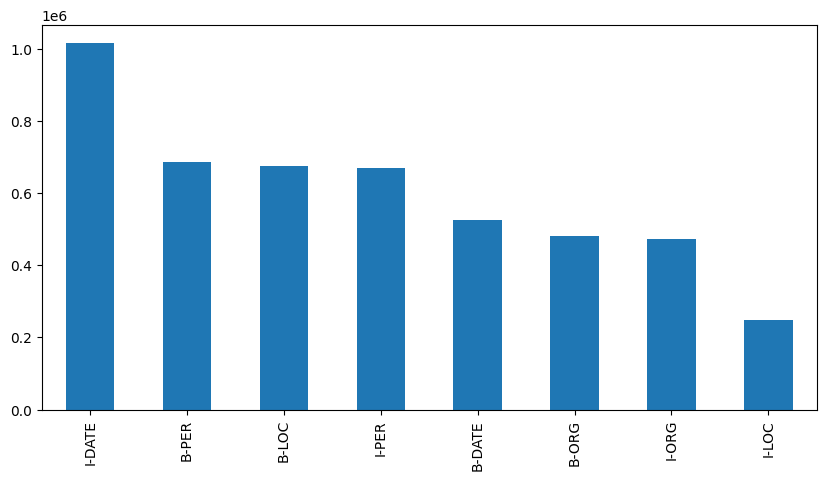

In [14]:
# representation of each entity tag
pd_augment_ner_iob_data[pd_augment_ner_iob_data.iob_tag != 'O']["iob_tag"]\
.value_counts().plot(kind="bar", figsize=(10,5))

# On remarque ici que le tag date représente 40% des tags (en position I ou B)

La phrase la plus longue contient 59 mots.
ID de la plus longue phrase 118931.

La phrase la plus longue du corpus est:
 Nwə yə pú kə yɔ̌ Fəládɛ̂ dɔ̂lɔ̌ Pásə́kà Tyə́ʼ kwɔ̂ʼ kɛ́bəŋ Yésô Tyə́ʼ fîʼ zhwenyə dɔ̂lɔ̌ Tyə́ʼ kwɔ̂ʼ kɛ́bəŋ Malyâ Krǐsì Lamadâŋ Laʼnwə mjʉ̀jʉ̀ Tá lə Ondo André Marie ( Mle 599 438 - T ) Tâdyə̌ mkətú' bə ě tʉɔthə́ bí pə dzə̌ é nə́ŋ cyə̂ mnə́ hɔ̂ bí nə́ pîŋ pú a fa' yə pǐŋ lə .


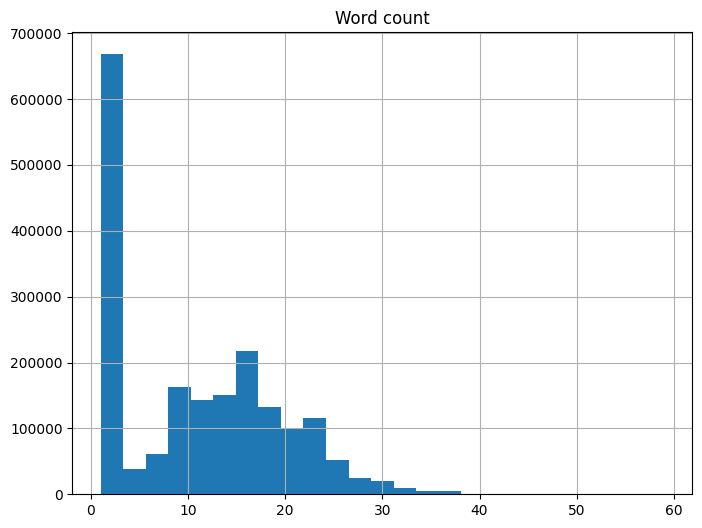

In [15]:

word_counts = pd_augment_ner_iob_data.groupby("sentence_id")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=25, figsize=(8,6))

# On constate que le nombre de mots moyens par phrase est de 15
MAX_LENGTH_SENTENCE = word_counts.max()[0]
print("La phrase la plus longue contient {} mots.".format(MAX_LENGTH_SENTENCE))
longest_sentence_id = word_counts[word_counts["Word count"]==MAX_LENGTH_SENTENCE].index[0]
print("ID de la plus longue phrase {}.".format(longest_sentence_id))
longest_sentence = pd_augment_ner_iob_data[pd_augment_ner_iob_data["sentence_id"]==longest_sentence_id]["word"].str.cat(sep=' ')
print(f"\nLa phrase la plus longue du corpus est:\n {longest_sentence}")


In [16]:
all_words = list(set(pd_augment_ner_iob_data["word"].values))
all_tags = list(set(pd_augment_ner_iob_data["iob_tag"].values))

print("Nombre de mots uniques: {}".format(pd_augment_ner_iob_data["word"].nunique()))
print("Nombre de tags uniques : {}".format(pd_augment_ner_iob_data["iob_tag"].nunique()))

Nombre de mots uniques: 6176
Nombre de tags uniques : 9


## 2- Features engineering

We will use differents kind of features to modelize our model. As ghomala is an african language, it is important to consider some of its features.

Any Bantu or semi-Bantu language use tone markers as morpho-syntatic properties to differentiate word or meaning. 

In [17]:
# Loading dependents libraries

import unidecode
import re
from datetime import datetime
import string
import math
import unicodedata

### 2.1. Features based on african linguistics specificities

In [ ]:
# importing features module 
from features import remove_accents, number_tone_word, extract_tone

In [18]:
# Constructing word features based on tones and API charaters
words_caracters = set([y.lower() for x in all_words for y in x])
all_caracters   = string.punctuation+string.ascii_letters+string.digits+''
tone_caracters  = list(set([x for x in words_caracters if x not in all_caracters]))
cpm_search      = re.compile(str(tone_caracters))

# Set of functions that normalizes and get features from datasets
bantou_tones = [f"{x} " for x in " ́̄̀̌̂" if x != " "]
string_tones = "".join(bantou_tones)
tones_search = re.compile(string_tones)

bantou_letters = string.ascii_letters+"ǝɔᵾɓɨşœɑʉɛɗŋøẅëïə"

non_tone = remove_accents("fə̀fə̀")

print(
    len("fə̀fə̀"), 
    len(non_tone), 
    number_tone_word("fə̀fə̀"), 
    "---"+extract_tone("fə̀fə̀")
)

print([x for x in "ntâmgǒ"])
print(tone_caracters, string_tones)

print(tone_caracters)

['ì', 'û', 'ǔ', 'ǝ', 'ş', 'ɑ', 'è', '̂', 'ù', '́', 'ê', 'á', 'ɓ', 'í', 'ó', '̧', '©', 'ě', 'à', 'é', 'ə', 'ú', 'ʉ', 'ɛ', 'ᵾ', 'î', 'ɨ', 'ç', 'ǐ', '̣', 'œ', 'ë', 'ʼ', 'ꞌ', 'ͻ', 'â', 'ǒ', 'ŋ', 'ò', 'ï', '̌', '᷆', 'ɔ', '᷅', '°', 'ô', 'ǎ', '̀']


### 2.2. Features based on word and its contexts

In [20]:
# l'ajout des tags suivants au mot courant améliore significativement le modèle
# l'ajout des informations sur les tons

from features import sent2features, sent2labels


### 2.3. Building all features and apply it to all datasets

With augmentation, you need more than 40 Giga of Ram to compute these features. This is was only possible with pro version of Google colab. You can also used others cloud notebook to run this.

In [21]:
# Build features from dataset 
print(len(pd_augment_ner_iob_data))

train_sents = [[word for word in sentence] for sentence in augmented_train_ner_data]
dev_sents = [[word for word in sentence] for sentence in extracted_dev_data]

Xtrain = [sent2features(s) for s in train_sents]
ytrain = [sent2labels(s) for s in train_sents]

Xdev = [sent2features(s) for s in dev_sents]
ydev = [sent2labels(s) for s in dev_sents]

print(f"Train X aug lenght: {len(Xtrain)} | {len(ytrain)}")
print(f"Dev X aug lenght: {len(Xdev)} | {len(ydev)}")
Xtrain[2]

20391461 15924


: 

: 

In [ ]:
Xtrain[2]

In [ ]:
project = "sangkak-02-2023-aug"
build_date = str(datetime.now()).replace(' ','_')

joblib.dump({
    "Xtrain": Xtrain, "ytrain": ytrain, 
    "Xdev": Xdev, "ydev": ydev
}, f'preprocessing/sangkak_featurised_augmented_train_dev_data_{build_date}.joblib') 


# 3. Modelling with CRF algorithm

In [14]:
# import dependents libraries

import pycrfsuite
#import sklearn_crfsuite
import math, string, re
import scipy
import joblib
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

### 3.1. Initialisation of pycrfsuite with training data

In [29]:
# trainer initialisation of pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)

for xseq, yseq in zip(Xtrain, ytrain):
    trainer.append(xseq, yseq)

In [40]:
project = "sangkak-02-2023-aug"
build_date = str(datetime.now()).replace(' ','_')
model_name = Path(f"models/with_aug/crf_pycrfsuite_{project}_{build_date}.model")
model_file = str(model_name)
file_crf = Path(f"models/with_aug/crf_pycrfsuite_{build_date}.object")

print(trainer.params())

params = {
    #"algorithm": 'lbfgs',
    "c1": 0.0920512484757745,
    "c2": 0.0328771171605105, 
    "max_iterations":100,
    #"verbose":True,
    "num_memories":10000,
    "epsilon": 1e-3,
    "linesearch": "MoreThuente",
    "max_linesearch":100000,
    "delta":1e-4,
    #"n_job":-1,
    #"c": 2,
    #"pa_type": 2,
    "feature.possible_transitions":True,
    "feature.possible_states":True, 
    #"model_filename": model_file
}

trainer.set_params(params)

['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']


### 3.2. Training and saving pycrfsuite model with training data

In [ ]:
trainer.train(model_file)

joblib.dump({"crf": trainer, "params": params}, file_crf) 

In [ ]:
trainer.logparser.last_iteration

# 4. Grid search: find best parameters for our models

In [ ]:
from sklearn_crfsuite import metrics


params = {
    "algorithm": 'lbfgs',
    "max_iterations":100,
    "verbose": False,
    #"job":-1,
    "all_possible_states":True,
    "all_possible_transitions":True, 
    "model_filename":model_file
}

crf_grill = pycrfsuite.Trainer(verbose=True)

labels = list(trainer.classes_)
labels.remove('O')

params_space = {
    'c1': scipy.stats.expon(scale=0.1),
    'c2': scipy.stats.expon(scale=0.05)
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf_grill, 
                        params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=5,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(Xtrain, ytrain)

In [ ]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [ ]:
#print(rs.cv_results_)
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_score_time']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(Xtest)
print(metrics.flat_classification_report(
    ytest, y_pred, labels=sorted_labels, digits=3
))

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])